In [71]:
import pandas as pd
import numpy as np

In [72]:
# Load the income data CSV
df_income = pd.read_csv("income_data.csv", encoding="unicode_escape")
df_income["age"] = pd.to_numeric(df_income.age.str.strip('+ years'))

In [73]:
# Have a look at the data to make sure it loaded correctly
df_income.head()

,region,age,2020
0,01 Stockholm county,16,4.6
1,01 Stockholm county,17,8.8
2,01 Stockholm county,18,17.8
3,01 Stockholm county,19,52.5
4,01 Stockholm county,20,112.0


In [74]:
# Group by age and get the mean income by age
df_income_by_age = df_income.groupby('age')['2020'].mean().reset_index()
df_income_by_age.head()

,age,2020
0,16,5.471429
1,17,10.552381
2,18,22.390476
3,19,65.376190
4,20,129.242857


## Task 1 - Linear regression with scikit-Learn

Coefficients: 
 [-0.40557442]
Mean squared error: 9974.39


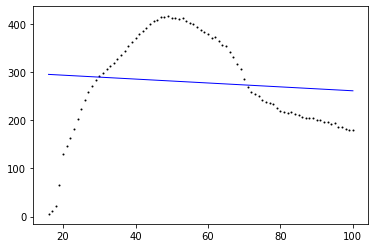

In [75]:
from turtle import width
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

# Check with sklearn linear regressor
x = df_income_by_age.age.values.reshape(-1, 1)
y = df_income_by_age["2020"].values

def fit_predict(x, y):
    linear_regressor = LinearRegression()
    linear_regressor.fit(x, y)

    # Make predictions using the testing set
    y_pred = linear_regressor.predict(x)

    # The coefficients
    print("Coefficients: \n", linear_regressor.coef_)
    # The mean squared error
    print("Mean squared error: %.2f" % mean_squared_error(y, y_pred))

    return y_pred

def plot_regression(x, y, y_pred):

    # Plot outputs
    plt.scatter(x, y, color="black", s=1)
    plt.plot(x, y_pred, color="blue", linewidth=1)
    plt.show()

y_pred = fit_predict(x, y)
plot_regression(x, y, y_pred)

The MSE values and plot are the same as in lab 2

## Task 2 - Polynomial regression with hyperparameter optimization

In [76]:
from sklearn.preprocessing import PolynomialFeatures
import itertools

def objective(degree):
    
    trans = PolynomialFeatures(degree=degree)
    x_new = trans.fit_transform(x)

    linear_regressor = LinearRegression()
    linear_regressor.fit(x_new, y)

    # Make predictions using the testing set
    y_pred = linear_regressor.predict(x_new)

    mse = mean_squared_error(y, y_pred)

    print(f"degree {degree} mse {mse}")

    return mse

# Define a simple grid search function that takes an objective function and will run it for all permutations of
# supplied argument ranges. For this part of the lab, we are only going to do a search on onr parameter (degree)
# but let's implement a more generic grid search that can search with multiple parameters. It will search for 
# the lowest value returned by the objective function
def simple_grid_search(fn_objective, args):

    # Get the grid values for all parameters
    all_grid_values = [v for _, v in args.items()]

    # Generate a dictionary of parameters & values for each step in the grid (essentially a cartesian 
    # product of all the parameter values)
    all_steps = []
    for element in itertools.product(*all_grid_values):
        all_steps.append({k:v for k,v in zip(args.keys(), element)})

    # Run the grid search
    grid_results = [fn_objective(**step) for step in all_steps]
        
    ix_best = np.argmin(grid_results)

    return all_steps[ix_best], grid_results[ix_best]


best_parameters, best_mse = simple_grid_search(objective, {"degree" : np.arange(1,16)})
best_degree = best_parameters["degree"]

print(f"The lowest MSE ({best_mse}) was found for degree = {best_parameters['degree']}")

degree 1 mse 9974.389821928748
degree 2 mse 2472.430468001994
degree 3 mse 210.5745996792746
degree 4 mse 193.6725553996026
degree 5 mse 186.8670736415558
degree 6 mse 71.84554051648777
degree 7 mse 68.06751971296345
degree 8 mse 53.42410605497298
degree 9 mse 64.4310030453029
degree 10 mse 607.9651085529713
degree 11 mse 1002.7401607756846
degree 12 mse 1526.0189713349478
degree 13 mse 2153.192767218665
degree 14 mse 2846.6396842132676
degree 15 mse 3565.1970224338365
The lowest MSE (53.42410605497298) was found for degree = 8


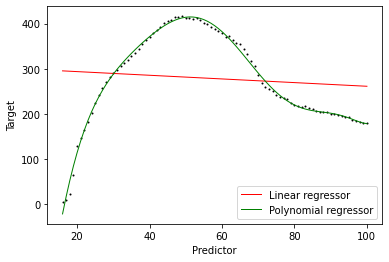

In [77]:
# Rerun the best case 
trans = PolynomialFeatures(degree=best_degree)
x_new = trans.fit_transform(x)

linear_regressor = LinearRegression()
linear_regressor.fit(x_new, y)

# Plot it together with the non polynomial regression
y_pred_new = linear_regressor.predict(x_new)

# Plot outputs
plt.scatter(x, y, color="black", s=1)
plt.plot(x, y_pred, color="red", linewidth=1)
plt.plot(x, y_pred_new, color="green", linewidth=1)
plt.xlabel("Predictor")
plt.ylabel("Target")

plt.legend(["Linear regressor", "Polynomial regressor"])
plt.show()

The linear regressor has an MSE of ca 9974 and the polynomial regressor with degree 8 (which was found via grid search) has an MSE of 53. The polynomial regressor has thus a significantly better fit to the data set (income by age) than the Linear regressor. The main reason for this is that the underlying data is not linear, and fits a polynomial model significantly better than a linear one. This is clearly seen in the plot above as well.

## Task 3 Clustering with K-means


In [78]:
df_income_vs_rent = pd.read_csv("inc_vs_rent.csv", index_col=0)
df_income_vs_rent.head()

,year,region,Annual rent sqm,Avg yearly inc KSEK
0,2020,01 Stockholm county,1341,350.303704
1,2020,03 Uppsala county,1303,306.916049
2,2020,04 Södermanland county,1129,283.756790
3,2020,05 Östergötland county,1144,289.500000
4,2020,06 Jönköping county,1044,287.470370


The data set appears to contain information about average rent in a rental apartment by year and region

<AxesSubplot:xlabel='Annual rent sqm', ylabel='Avg yearly inc KSEK'>

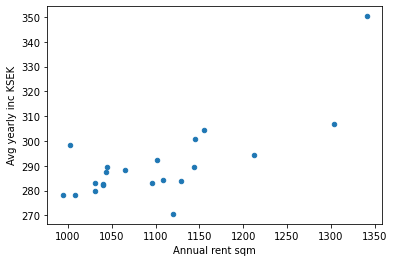

In [79]:
# We start by creating a scatter plot for the data points, relating square meters to rent.
df_income_vs_rent.plot.scatter(x="Annual rent sqm", y="Avg yearly inc KSEK")

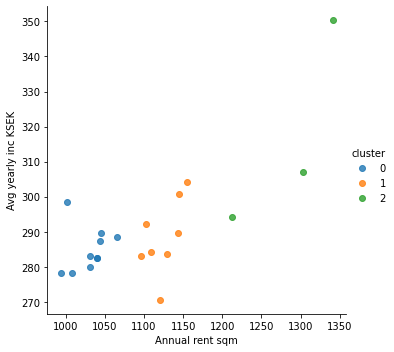

In [80]:
from random import randint

# Eucledian distance between a point a and a list of points b
def eucledian_distance(a, b):
    return np.sqrt(np.sum((a - b)**2, axis=1))

def my_kmeans(data, clusters, fn_distance, max_iterations = 10):

    # Randomly select centroid start points from the dataset, we need as many centroids as the wanted number of clusters
    centroids = [data[randint(0,data.shape[0]-1)] for _ in range(clusters)]

    # Iterate and adjust centroids until we have convergence (or iterations > max_iterations)
    iter = 0

    while iter < max_iterations:

        # Find the closest centroid for each point, by checking the distance between all points and centroids
        closest_points_to_centroid = [[] for _ in range(clusters)]

        for x in data:
            # Find the closest centroid
            centroid_idx = np.argmin(fn_distance(x, centroids))
            # Add to list of points for the given centroid
            closest_points_to_centroid[centroid_idx].append(x)

        # Let's calculate new centroids by taking the mean of all the points in each cluster
        new_centroids = [[] for _ in range(clusters)]

        for i, cluster_points in enumerate(closest_points_to_centroid):

            if len(cluster_points) == 0:
                # Empty cluster, let's use the old centroid
                new_centroids[i] = centroids[i]
            else:
                # Get the mean
                new_centroids[i] = np.mean(cluster_points, axis=0)
        
        # If the new centroids are the same as the last then we have converged
        if np.all(np.equal(centroids, new_centroids)):
            break

        centroids = new_centroids
        iter += 1

    # We now have the converged (or we have reached max iterations) centroids now, go through a final
    # time and assign points to each of the clusters/centroids and return both the centroids as well
    # as the centroid/cluster assignment
    all_centroids = []
    all_centroid_ixs = []

    for x in data:
        centroid_idx = np.argmin(fn_distance(x, centroids))
        all_centroids.append(centroids[centroid_idx])
        all_centroid_ixs.append(centroid_idx)

    return all_centroids, all_centroid_ixs

x = df_income_vs_rent[["Annual rent sqm", "Avg yearly inc KSEK"]].values.astype(np.float32)
centroids, assigned_clusters = my_kmeans(x, 3, fn_distance = eucledian_distance)

# Add the assigned cluster to the data frame
df_income_vs_rent["cluster"] = assigned_clusters

# Do a scatter plot again but this time color the points with the cluster index
import seaborn as sns
sns.lmplot(x="Annual rent sqm", y="Avg yearly inc KSEK", data=df_income_vs_rent, hue="cluster", fit_reg=False)


## Task 4 Grid search for hyper-parameter optimization

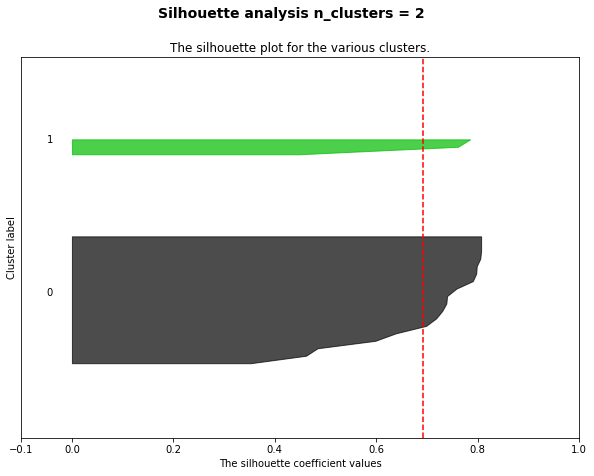

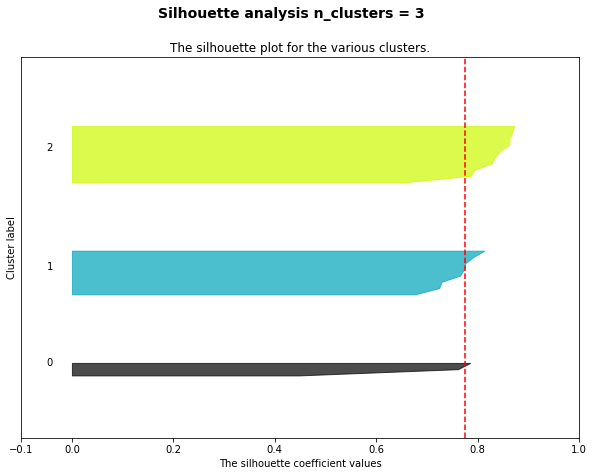

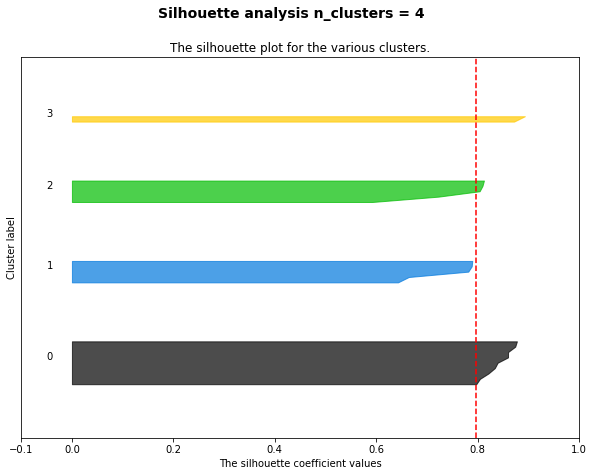

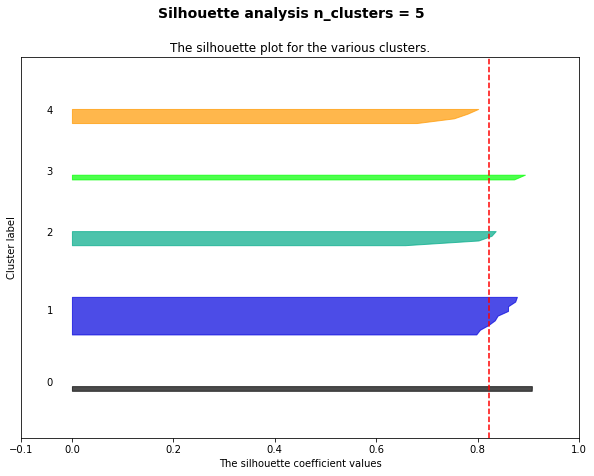

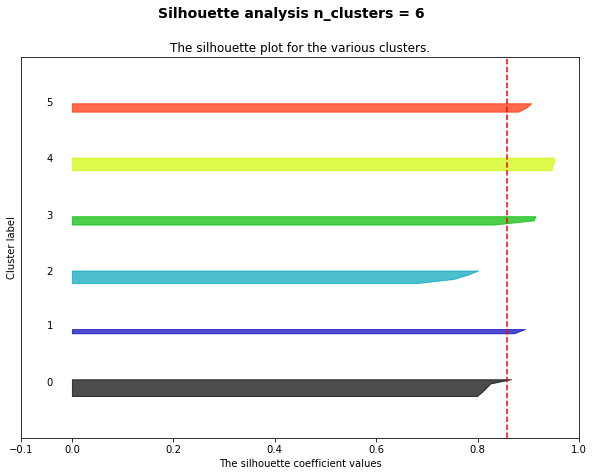

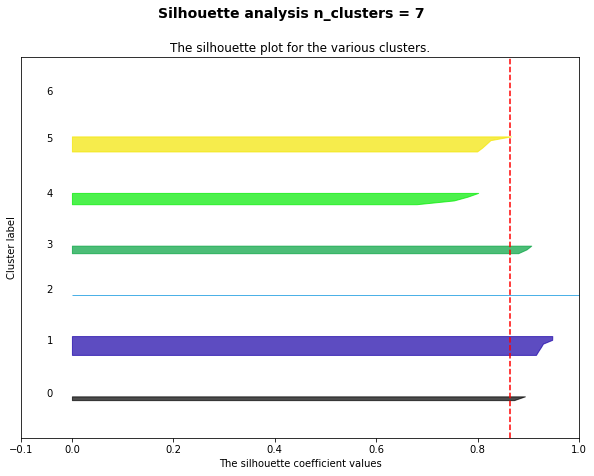

In [87]:
# Calculate the mean distance between a given point and a list of other points
from re import S


def mean_distance(point, points_in_cluster):
    return np.mean(eucledian_distance(point, points_in_cluster))

# Calcuate intra cluster distance for a given point index
def mean_intra_cluster_distance(all_points, all_clusters, ix_point):
    cluster =  all_clusters[ix_point]

    return mean_distance(all_points[ix_point], all_points[all_clusters == cluster])


# Calcuate inter cluster distance for a given point index
def mean_inter_cluster_distance(all_points, all_clusters, ix_point):
    cluster =  all_clusters[ix_point]

    return mean_distance(all_points[ix_point], all_points[all_clusters != cluster])

# Calculate the silhoette coefficients for a given set of points and cluster assignments
def silhouette_coefficients(all_points, all_clusters):

    n = all_points.shape[0]

    a = np.array([mean_intra_cluster_distance(all_points, all_clusters, i) for i in range(n)])
    b = np.array([mean_inter_cluster_distance(all_points, all_clusters, i) for i in range(n)])

    s = (b - a) / np.maximum(a, b)

    return s

import matplotlib.cm as cm

def silhouette_plot(n_clusters, sample_silhouette_values, cluster_labels):

    #
    # Source: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    #

    silhouette_avg = np.mean(sample_silhouette_values)

    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(10, 7)

    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(sample_silhouette_values) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(
        f"Silhouette analysis n_clusters = {n_clusters}",
        fontsize=14,
        fontweight="bold",
    )

for n_clusters in range(2, 8):
    centroids, assigned_clusters = my_kmeans(x, n_clusters, fn_distance = eucledian_distance)
    coeffs = silhouette_coefficients(x, assigned_clusters)

    silhouette_plot(n_clusters, coeffs, np.array(assigned_clusters))


Baesd on the silhoutte plots above, it would appear that 4-6 clusters look pretty good with wide plots (close to 1 in coefficient), and mostly over the mean line. Let's select 6 as that also has the highest overall mean coefficient score.

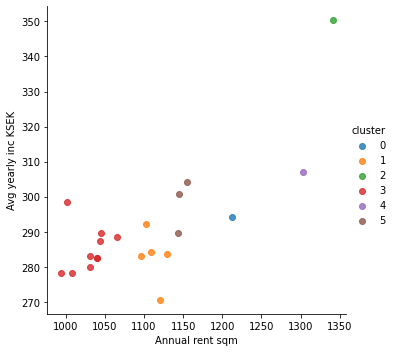

In [88]:
n_clusters = 6

centroids, assigned_clusters = my_kmeans(x, n_clusters, fn_distance = eucledian_distance)

# Add the assigned cluster to the data frame
df_income_vs_rent["cluster"] = assigned_clusters

# Do a scatter plot again but this time color the points with the cluster index
import seaborn as sns
sns.lmplot(x="Annual rent sqm", y="Avg yearly inc KSEK", data=df_income_vs_rent, hue="cluster", fit_reg=False)


## Optional advanced task - create N dimensional grid search optimizer

The grid search function implemented above can handle an arbitrary number of hyper parameters. It does so by creating a cartesian product of all parameter values.